* 请在环境变量中设置`DB_URI`指向数据库

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from PyFin.api import *
from alphamind.api import *
from alphamind.strategy.strategy import Strategy, RunningSetting
from matplotlib import pyplot as plt

plt.style.use('ggplot')

In [2]:
# Back test parameter settings
start_date = '2016-01-01'
end_date = '2018-03-30'

freq = '10b'
industry_name = 'sw'
industry_level = 1
turn_over_target = 0.4
batch = 1
horizon = map_freq(freq)
weights_bandwidth = 0.01
universe = Universe('zz800')
data_source = os.environ['DB_URI']
benchmark_code = 905
method = 'risk_neutral'

In [3]:
# Model settings
alpha_factors = {
    'f01': CSQuantiles(LAST('EPS'), groups='sw1'),
    'f02': CSQuantiles(LAST('ROE'), groups='sw1'),
    }

weights = dict(f01=1.,
               f02=1.)

alpha_model = ConstLinearModel(features=alpha_factors, weights=weights)

data_meta = DataMeta(freq=freq,
                     universe=universe,
                     batch=1,
                     neutralized_risk=None,
                     pre_process=None,
                     post_process=None,
                     data_source=data_source)

In [4]:
# Constraintes settings

industry_names = industry_list(industry_name, industry_level)
constraint_risk = ['SIZE', 'SIZENL', 'BETA']
total_risk_names = constraint_risk + ['benchmark', 'total']
all_styles = risk_styles + industry_styles + macro_styles

b_type = []
l_val = []
u_val = []

previous_pos = pd.DataFrame()
rets = []
turn_overs = []
leverags = []

for name in total_risk_names:
    if name == 'benchmark':
        b_type.append(BoundaryType.RELATIVE)
        l_val.append(0.8)
        u_val.append(1.0)
    else:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(0.0)
        u_val.append(0.0)

bounds = create_box_bounds(total_risk_names, b_type, l_val, u_val)

In [5]:
# Running settings
running_setting = RunningSetting(weights_bandwidth=weights_bandwidth,
                                 rebalance_method=method,
                                 bounds=bounds,
                                 turn_over_target=turn_over_target)

In [6]:
# Strategy
strategy = Strategy(alpha_model,
                    data_meta,
                    universe=universe,
                    start_date=start_date,
                    end_date=end_date,
                    freq=freq,
                    benchmark=benchmark_code)

strategy.prepare_backtest_data()
ret_df, positions = strategy.run(running_setting=running_setting)

2019-02-10 00:33:29,656 - ALPHA_MIND - INFO - alpha factor data loading finished ...
2019-02-10 00:33:30,687 - ALPHA_MIND - INFO - industry data loading finished ...
2019-02-10 00:33:31,236 - ALPHA_MIND - INFO - benchmark data loading finished ...
2019-02-10 00:33:36,367 - ALPHA_MIND - INFO - risk_model data loading finished ...
2019-02-10 00:33:40,488 - ALPHA_MIND - INFO - returns data loading finished ...
2019-02-10 00:33:40,798 - ALPHA_MIND - INFO - starting backting ...
2019-02-10 00:33:41,103 - ALPHA_MIND - INFO - alpha models training finished ...
D:\ProgramData\anaconda3\lib\site-packages\pandas\core\frame.py:4024: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
2019-02-10 00:33:41,174 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 re-balance: 799 codes
2019-02-10 00:33:41,241 - ALPHA_MIND 

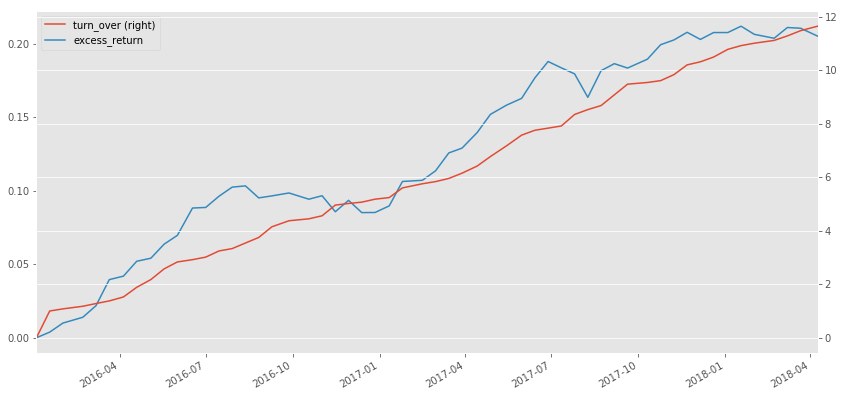

In [7]:
ret_df[['turn_over', 'excess_return']].cumsum().plot(figsize=(14, 7), secondary_y='turn_over')